Importing data from Local to Googel Colab's Server

In [ ]:
 from google.colab import files
uploaded = files.upload()

Saving household_power_consumption.txt to household_power_consumption.txt


**Cleaning the dataset**

In [ ]:
import pandas as pd

# Load CSV with semicolon separator
df = pd.read_csv('household_power_consumption.txt', sep=';', na_values='?')

# Combine 'date' and 'time' into one datetime column
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')

# Set datetime as index
df.set_index('datetime', inplace=True)

# Drop original 'date' and 'time'
df.drop(['Date', 'Time'], axis=1, inplace=True)

# Convert target column to numeric
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')

# Now resample correctly (use lowercase 'h' instead of deprecated 'H')
df_power_hourly = df[['Global_active_power']].resample('h').mean()

# Fill missing values
df_power_hourly.fillna(method='ffill', inplace=True)

# Confirm
print(df_power_hourly.head())

                     Global_active_power
datetime                                
2006-12-16 17:00:00             4.222889
2006-12-16 18:00:00             3.632200
2006-12-16 19:00:00             3.400233
2006-12-16 20:00:00             3.268567
2006-12-16 21:00:00             3.056467


/tmp/ipython-input-9-2447886274.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_power_hourly.fillna(method='ffill', inplace=True)


In [ ]:
df_power_hourly['hour'] = df_power_hourly.index.hour
df_power_hourly['dayofweek'] = df_power_hourly.index.dayofweek
df_power_hourly['is_weekend'] = (df_power_hourly['dayofweek'] >= 5).astype(int)

**Training Binary Classification Model**

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Train-test split
train = df_power_hourly['Global_active_power'][:-168]  # last 7 days for test
test = df_power_hourly['Global_active_power'][-168:]

# Fit ARIMA
model_arima = ARIMA(train, order=(2,1,2))
model_arima_fit = model_arima.fit()
forecast_arima = model_arima_fit.forecast(steps=168)

# Evaluation
mae_arima = mean_absolute_error(test, forecast_arima)
rmse_arima = np.sqrt(mean_squared_error(test, forecast_arima))
print(f"ARIMA - MAE: {mae_arima:.2f}, RMSE: {rmse_arima:.2f}")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA - MAE: 0.70, RMSE: 0.86


In [ ]:
!pip install prophet --quiet

from prophet import Prophet

df_prophet = df_power_hourly.reset_index()[['datetime', 'Global_active_power']].rename(columns={'datetime': 'ds', 'Global_active_power': 'y'})
train_prophet = df_prophet[:-168]
test_prophet = df_prophet[-168:]

model_prophet = Prophet()
model_prophet.fit(train_prophet)

future = model_prophet.make_future_dataframe(periods=168, freq='H')
forecast_prophet = model_prophet.predict(future)

# Evaluation
y_true = test_prophet['y'].values
y_pred = forecast_prophet['yhat'][-168:].values
mae_prophet = mean_absolute_error(y_true, y_pred)
rmse_prophet = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"Prophet - MAE: {mae_prophet:.2f}, RMSE: {rmse_prophet:.2f}")

DEBUG:cmdstanpy:input tempfile: /tmp/tmpuh74y4v0/efeek4rq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuh74y4v0/xqjmbaqa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88566', 'data', 'file=/tmp/tmpuh74y4v0/efeek4rq.json', 'init=/tmp/tmpuh74y4v0/xqjmbaqa.json', 'output', 'file=/tmp/tmpuh74y4v0/prophet_modela40fs5pr/prophet_model-20250714064726.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:47:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:47:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


Prophet - MAE: 0.60, RMSE: 0.76


In [ ]:
!pip install xgboost --quiet
import xgboost as xgb

# Prepare features
df_ml = df_power_hourly.dropna().copy()
features = ['hour', 'dayofweek', 'is_weekend']
target = 'Global_active_power'

X = df_ml[features]
y = df_ml[target]

# Train-test split
X_train, X_test = X[:-168], X[-168:]
y_train, y_test = y[:-168], y[-168:]

# Fit model
model_xgb = xgb.XGBRegressor()
model_xgb.fit(X_train, y_train)

y_pred_xgb = model_xgb.predict(X_test)

# Evaluation
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f"XGBoost - MAE: {mae_xgb:.2f}, RMSE: {rmse_xgb:.2f}")

XGBoost - MAE: 0.48, RMSE: 0.69


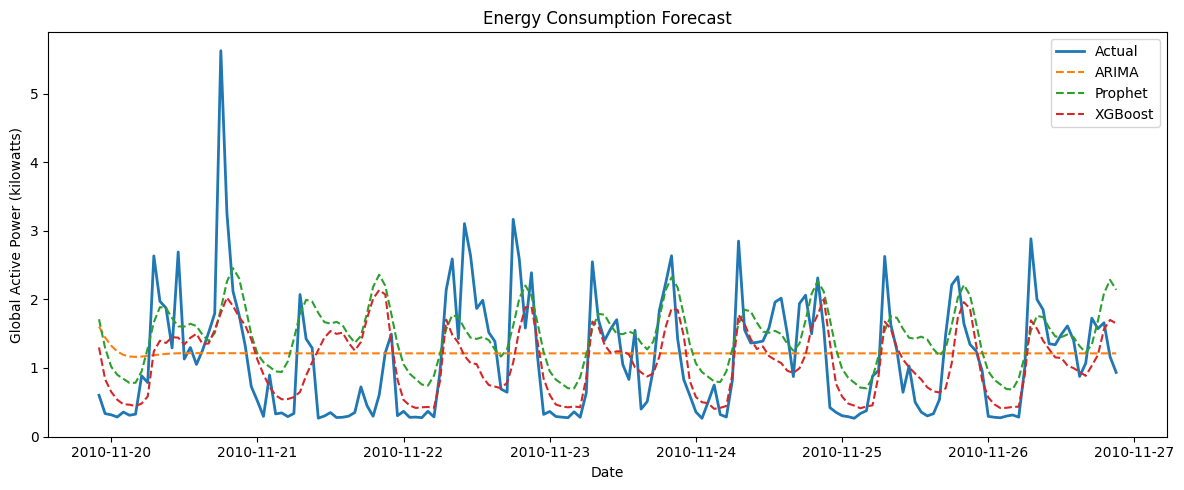

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(test.index, test, label='Actual', linewidth=2)
plt.plot(test.index, forecast_arima, label='ARIMA', linestyle='--')
plt.plot(test.index, y_pred, label='Prophet', linestyle='--')
plt.plot(test.index, y_pred_xgb, label='XGBoost', linestyle='--')
plt.title('Energy Consumption Forecast')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend()
plt.tight_layout()
plt.show()

**Problem Statement and Objective**

Forecast short-term household energy usage using historical time-based patterns.

**Dataset Description and Loading**

This Dataset is downloaded from Kaggle and it has Date, time, Global_Active_Power, Global_REactive_Power, Voltage, global_intensity, sub_metering_1, sub_metering_2 and sub_metering_3 columns, and data of each day for 4 years i.e from 2016 to 2020.

It was loaded directly into Google Colab's Server using import Statement.

**Data Cleaning and Preprocessing**

1. Merged Date and Time into single DateTime Column.
2. Filled out missing values with Forwrd fill method.
3. Converted 'Global_Active_Power' column to number datatype fro Object.

**Model Building and Evaluation**

Plotted Acutal vs Forcasted Energy Usage using multiple line charts.